# Lab 3
Author: Ksenofontov Gregory

Task: Plot vector field for autoencoder. Plot heatmap of dataset likelihood from VAE. Compare results. Datasets: multiple synthetic, similar to datasets used in the [article](https://jmlr.csail.mit.edu/papers/volume15/alain14a/alain14a.pdf).

Implementation

In [ ]:
!pip install flax optax distrax

In [2]:
import numpy as np

import jax.numpy as jnp
from jax import random, grad, jit
from jax.scipy import stats

from flax import linen as nn
import optax
from flax.training import train_state

from distrax import Normal

import matplotlib.pyplot as plt
from tqdm import tqdm

Init some constants

In [3]:
SEED = random.PRNGKey(50)
data_size = 10000

Create data as given in article

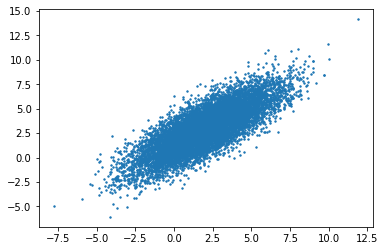

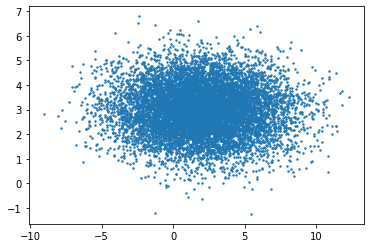

In [4]:
def generate_2d_data(count, mode='univariate'):
    assert mode in ['univariate', 'multivariate']
    mean = [[2.0, 3.0]]
    sigma = [[3.0, 1.0]]
    if mode == 'univariate':
        rotate = [
            [1.0, 0.0], 
            [0.0, 1.0]
        ]
    else:
        rotate = [
            [jnp.sqrt(2) / 2, jnp.sqrt(2) / 2], 
            [-jnp.sqrt(2) / 2, jnp.sqrt(2) / 2]
        ]
    data = jnp.array(mean) + jnp.array((np.random.randn(count, 2) * sigma)) @ jnp.array(rotate)
    return data

multi_ds = generate_2d_data(data_size, mode='multivariate')
plt.scatter(multi_ds[:, 0], multi_ds[:, 1], s=2)
plt.show()

uni_ds = generate_2d_data(data_size, mode='univariate')
plt.scatter(uni_ds[:, 0], uni_ds[:, 1], s=2)
plt.show()

Models trainer

In [5]:
class Trainer:

  def __init__(self, seed, model, optimizer, init_shape=[1, 2]):
    """Creates initial TrainState"""
    self.seed = seed
    self.model = model
    params = self.model.init(seed, jnp.ones(init_shape))['params'] # initialize parameters by passing a template data
    self.state =  train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

  
  def _train_step(self, batch):
    """Train for a single step."""
    def criterion(params):
      preds = self.model.apply({'params': params}, batch)
      loss = self.model.loss(batch, preds)
      return loss
    
    # Calculate loss on step
    loss = criterion(self.state.params)

    # Calculate grads on step
    grad_criterion  = grad(criterion)
    grads = grad_criterion(self.state.params)

    # Apply calculated gradiensts
    self.state = self.state.apply_gradients(grads=grads)
    return loss


  def _train_epoch(self, dataset, batch_size):
    """Train for a single epoch."""
    dataset_size = len(dataset)
    steps_per_epoch = dataset_size // batch_size

    # Create permutations of dataset by batches 
    perm_seed = random.PRNGKey(int(random.randint(self.seed, minval=0, maxval=1000, shape=(1,))))
    perms = random.permutation(perm_seed, dataset_size) # Get a randomized index array
    perms = perms[:steps_per_epoch * batch_size]  # Skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size)) # Index array, where each row is a batch

    losses = []
    # Train on batches
    for perm in perms:
      batch = dataset[perm, ...] # dict{'x': array, 'y': array}
      loss = self._train_step(jnp.array(batch))
      losses.append(loss)
    return losses

  def train(self, dataset, epochs, batch_size, verbose_step=0):
    losses = []
    for epoch in tqdm(range(1, epochs + 1)):
      # Run an optimization step over a training batch
      loss = self._train_epoch(dataset, batch_size)
      if epoch % verbose_step == 0:
        print(f'epoch: {epoch}, loss: {jnp.array(loss).mean():.6f}')
      losses.extend(loss)
    return losses, self.state.params

Let's define and train AE on two datasets

In [6]:
class AE(nn.Module):   
    
    @nn.compact
    def __call__(self, x):
      x = nn.Dense(1000)(x)
      x = nn.tanh(x)
      return nn.Dense(2)(x)
      
    # aka MSE
    def loss(self, preds, y):
      return jnp.mean((y - preds)**2)

 17%|█▋        | 10/60 [00:20<00:50,  1.01s/it]

epoch: 10, loss: 0.090531


 33%|███▎      | 20/60 [00:28<00:32,  1.23it/s]

epoch: 20, loss: 0.027341


 50%|█████     | 30/60 [00:36<00:24,  1.21it/s]

epoch: 30, loss: 0.016213


 67%|██████▋   | 40/60 [00:44<00:16,  1.23it/s]

epoch: 40, loss: 0.010229


 83%|████████▎ | 50/60 [00:53<00:08,  1.16it/s]

epoch: 50, loss: 0.007199


100%|██████████| 60/60 [01:01<00:00,  1.02s/it]

epoch: 60, loss: 0.004775


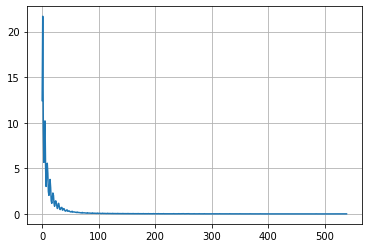

In [7]:
epochs = 60
batch_size = 1024

multi_ae = AE()
optimizer = optax.adamw(learning_rate=1e-2)
trainer = Trainer(SEED, multi_ae, optimizer)
losses, multi_ae_params = trainer.train(multi_ds, epochs, batch_size, verbose_step=10)
  
plt.grid()
plt.plot(losses)
plt.show()

 17%|█▋        | 10/60 [00:07<00:39,  1.26it/s]

epoch: 10, loss: 0.084704


 33%|███▎      | 20/60 [00:15<00:31,  1.26it/s]

epoch: 20, loss: 0.025614


 50%|█████     | 30/60 [00:24<00:24,  1.22it/s]

epoch: 30, loss: 0.012990


 67%|██████▋   | 40/60 [00:32<00:16,  1.22it/s]

epoch: 40, loss: 0.007595


 83%|████████▎ | 50/60 [00:41<00:08,  1.21it/s]

epoch: 50, loss: 0.004958


100%|██████████| 60/60 [00:49<00:00,  1.22it/s]

epoch: 60, loss: 0.007897


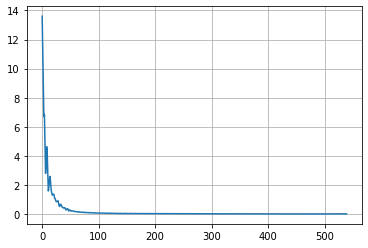

In [8]:
epochs = 60
batch_size = 1024

uni_ae = AE()
optimizer = optax.adamw(learning_rate=1e-2)
trainer = Trainer(SEED, uni_ae, optimizer)
losses, uni_ae_params = trainer.train(uni_ds, epochs, batch_size, verbose_step=10)
  
plt.grid()
plt.plot(losses)
plt.show()

Let's define and train VAE on two datasets

In [9]:
class VAE(nn.Module):
    def setup(self):
      self.encoder = nn.Dense(2)
      self.decoder = nn.Dense(4)
   
    def __call__(self, x):
      mu_z, log_std_z = nn.tanh(self.encoder(x)).split(2, axis=1)
      eps = self.prior(log_std_z.shape)
      z = jnp.exp(log_std_z) * eps + mu_z
      mu_x, log_std_x = self.decoder(z).split(2, axis=1)
      return mu_z, log_std_z, mu_x, log_std_x

    def prior(self, n):
        return random.normal(SEED, shape=n)
      
    def loss(self, x, preds):
      mu_z, log_std_z, mu_x, log_std_x = preds
      p = Normal(mu_x, jnp.exp(log_std_x))
      q = Normal(jnp.zeros_like(mu_z), jnp.exp(jnp.zeros_like(log_std_z)))
      kl_div = p.kl_divergence(q)
      nll = -p.log_prob(x)
      return kl_div.mean() + nll.mean()

  5%|▌         | 10/200 [00:11<03:26,  1.09s/it]

epoch: 10, loss: 4.596707


 10%|█         | 20/200 [00:22<03:17,  1.10s/it]

epoch: 20, loss: 4.065609


 15%|█▌        | 30/200 [00:33<03:06,  1.10s/it]

epoch: 30, loss: 3.784760


 20%|██        | 40/200 [00:45<03:04,  1.16s/it]

epoch: 40, loss: 3.612373


 25%|██▌       | 50/200 [00:58<02:55,  1.17s/it]

epoch: 50, loss: 3.505090


 30%|███       | 60/200 [01:09<02:36,  1.12s/it]

epoch: 60, loss: 3.438318


 35%|███▌      | 70/200 [01:20<02:21,  1.09s/it]

epoch: 70, loss: 3.396788


 40%|████      | 80/200 [01:31<02:09,  1.08s/it]

epoch: 80, loss: 3.370820


 45%|████▌     | 90/200 [01:42<02:06,  1.15s/it]

epoch: 90, loss: 3.354198


 50%|█████     | 100/200 [01:54<01:50,  1.11s/it]

epoch: 100, loss: 3.342987


 55%|█████▌    | 110/200 [02:05<01:39,  1.10s/it]

epoch: 110, loss: 3.334795


 60%|██████    | 120/200 [02:16<01:28,  1.11s/it]

epoch: 120, loss: 3.328252


 65%|██████▌   | 130/200 [02:27<01:19,  1.13s/it]

epoch: 130, loss: 3.322625


 70%|███████   | 140/200 [02:38<01:04,  1.08s/it]

epoch: 140, loss: 3.317542


 75%|███████▌  | 150/200 [02:50<00:57,  1.15s/it]

epoch: 150, loss: 3.312821


 80%|████████  | 160/200 [03:01<00:43,  1.09s/it]

epoch: 160, loss: 3.308361


 85%|████████▌ | 170/200 [03:11<00:32,  1.09s/it]

epoch: 170, loss: 3.304096


 90%|█████████ | 180/200 [03:22<00:22,  1.12s/it]

epoch: 180, loss: 3.299967


 95%|█████████▌| 190/200 [03:33<00:10,  1.07s/it]

epoch: 190, loss: 3.295925


100%|██████████| 200/200 [03:44<00:00,  1.12s/it]

epoch: 200, loss: 3.291931


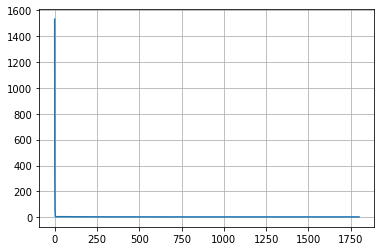

In [13]:
epochs = 200
batch_size = 1024

multi_vae = VAE()
optimizer = optax.adamw(learning_rate=1e-2)
trainer = Trainer(SEED, multi_vae, optimizer)
losses, multi_vae_params = trainer.train(multi_ds, epochs, batch_size, verbose_step=10)
  
plt.grid()
plt.plot(losses)
plt.show()

  5%|▌         | 10/200 [00:12<04:07,  1.30s/it]

epoch: 10, loss: 7.761494


 10%|█         | 20/200 [00:24<03:25,  1.14s/it]

epoch: 20, loss: 6.001892


 15%|█▌        | 30/200 [00:35<03:07,  1.10s/it]

epoch: 30, loss: 5.186492


 20%|██        | 40/200 [00:46<02:54,  1.09s/it]

epoch: 40, loss: 4.777752


 25%|██▌       | 50/200 [00:57<02:44,  1.10s/it]

epoch: 50, loss: 4.508381


 30%|███       | 60/200 [01:08<02:32,  1.09s/it]

epoch: 60, loss: 4.293392


 35%|███▌      | 70/200 [01:19<02:22,  1.10s/it]

epoch: 70, loss: 4.111036


 40%|████      | 80/200 [01:30<02:16,  1.14s/it]

epoch: 80, loss: 3.955246


 45%|████▌     | 90/200 [01:41<02:00,  1.09s/it]

epoch: 90, loss: 3.823196


 50%|█████     | 100/200 [01:52<01:50,  1.10s/it]

epoch: 100, loss: 3.712686


 55%|█████▌    | 110/200 [02:03<01:38,  1.09s/it]

epoch: 110, loss: 3.621630


 60%|██████    | 120/200 [02:14<01:26,  1.08s/it]

epoch: 120, loss: 3.547926


 65%|██████▌   | 130/200 [02:26<01:22,  1.17s/it]

epoch: 130, loss: 3.489437


 70%|███████   | 140/200 [02:37<01:08,  1.14s/it]

epoch: 140, loss: 3.444005


 75%|███████▌  | 150/200 [02:48<00:54,  1.09s/it]

epoch: 150, loss: 3.409488


 80%|████████  | 160/200 [02:59<00:43,  1.08s/it]

epoch: 160, loss: 3.383828


 85%|████████▌ | 170/200 [03:10<00:32,  1.08s/it]

epoch: 170, loss: 3.365125


 90%|█████████ | 180/200 [03:21<00:21,  1.10s/it]

epoch: 180, loss: 3.351701


 95%|█████████▌| 190/200 [03:32<00:11,  1.12s/it]

epoch: 190, loss: 3.342142


100%|██████████| 200/200 [03:44<00:00,  1.12s/it]

epoch: 200, loss: 3.335316


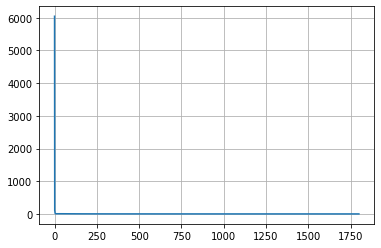

In [14]:
epochs = 200
batch_size = 1024

uni_vae = VAE()
optimizer = optax.adamw(learning_rate=1e-1)
trainer = Trainer(SEED, uni_vae, optimizer)
losses, uni_vae_params = trainer.train(uni_ds, epochs, batch_size, verbose_step=10)
  
plt.grid()
plt.plot(losses)
plt.show()

Finally plot vector fields of AEs and heatmaps of VAEs

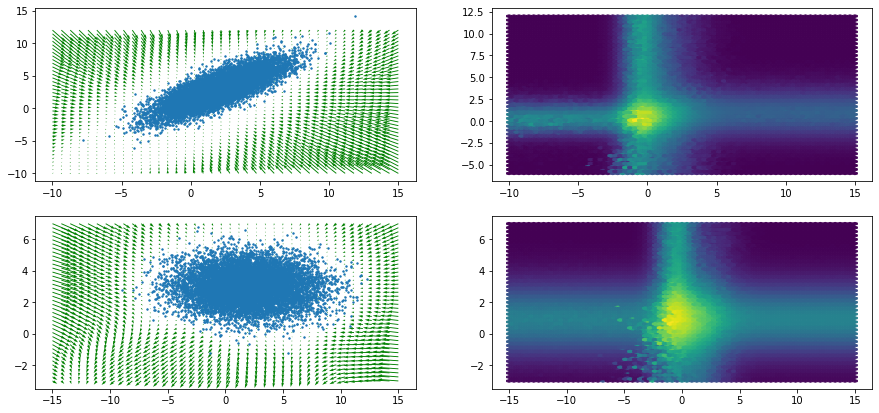

In [19]:
fig, ((multi_vector_field, multi_heatmap), (uni_vector_field, uni_heatmap)) = plt.subplots(2, 2, figsize=(15, 7))


############## Vector field AE ##############
# Multivariate data
x_, y_ = jnp.meshgrid(jnp.linspace(-10, 15, 40), jnp.linspace(-10, 12, 40))
x = jnp.concatenate([x_[:,:,None], y_[:,:,None]], axis=-1).reshape(-1, 2)
preds = multi_ae.apply({'params': multi_ae_params}, x)

u = preds[:, 0] - x_.reshape(-1)
v = preds[:, 1] - y_.reshape(-1)

multi_vector_field.quiver(x_, y_, u, v, color='g')
multi_vector_field.scatter(multi_ds[:, 0], multi_ds[:, 1], s=2)

# Univariate data
x_, y_ = jnp.meshgrid(jnp.linspace(-15, 15, 40), jnp.linspace(-3, 7, 40))
x = jnp.concatenate([x_[:,:,None], y_[:,:,None]], axis=-1).reshape(-1, 2)
preds = uni_ae.apply({'params': uni_ae_params}, x)

u = preds[:, 0] - x_.reshape(-1)
v = preds[:, 1] - y_.reshape(-1)

uni_vector_field.quiver(x_, y_, u, v, color='g')
uni_vector_field.scatter(uni_ds[:, 0], uni_ds[:, 1], s=2)


############## Heatmap VAE ##############
x_, y_ = jnp.meshgrid(jnp.linspace(-10, 15, 200), jnp.linspace(-6, 12, 200))
x = jnp.concatenate([x_[:,:,None], y_[:,:,None]], axis=-1).reshape(-1, 2)

# Multivariate data
model_bd = multi_vae.bind({'params': multi_vae_params})
_, _, mu_x, log_std_x = model_bd(x)

likelihoods = Normal(mu_x, jnp.exp(log_std_x)).prob(x).reshape(200, 200, -1)

multi_heatmap.hexbin(x_.flatten(), y_.flatten(), likelihoods.mean(-1).flatten(), gridsize=70)

# Univariate data
x_, y_ = jnp.meshgrid(jnp.linspace(-15, 15, 200), jnp.linspace(-3, 7, 200))
x = jnp.concatenate([x_[:,:,None], y_[:,:,None]], axis=-1).reshape(-1, 2)
model_bd = uni_vae.bind({'params': uni_vae_params})
_, _, mu_x, log_std_x = model_bd(x)

likelihoods = Normal(mu_x, jnp.exp(log_std_x)).prob(x).reshape(200, 200, -1)

uni_heatmap.hexbin(x_.flatten(), y_.flatten(), likelihoods.mean(-1).flatten(), gridsize=70)

plt.show()

Результаты обучения VAE оставляют желать лучшего, однако можно заметить схожий вид что и данные.
В AE можно заметить что с отдалением от данных вектора начинают вести странным образом. Это так же было отмечено в приведенной статье.